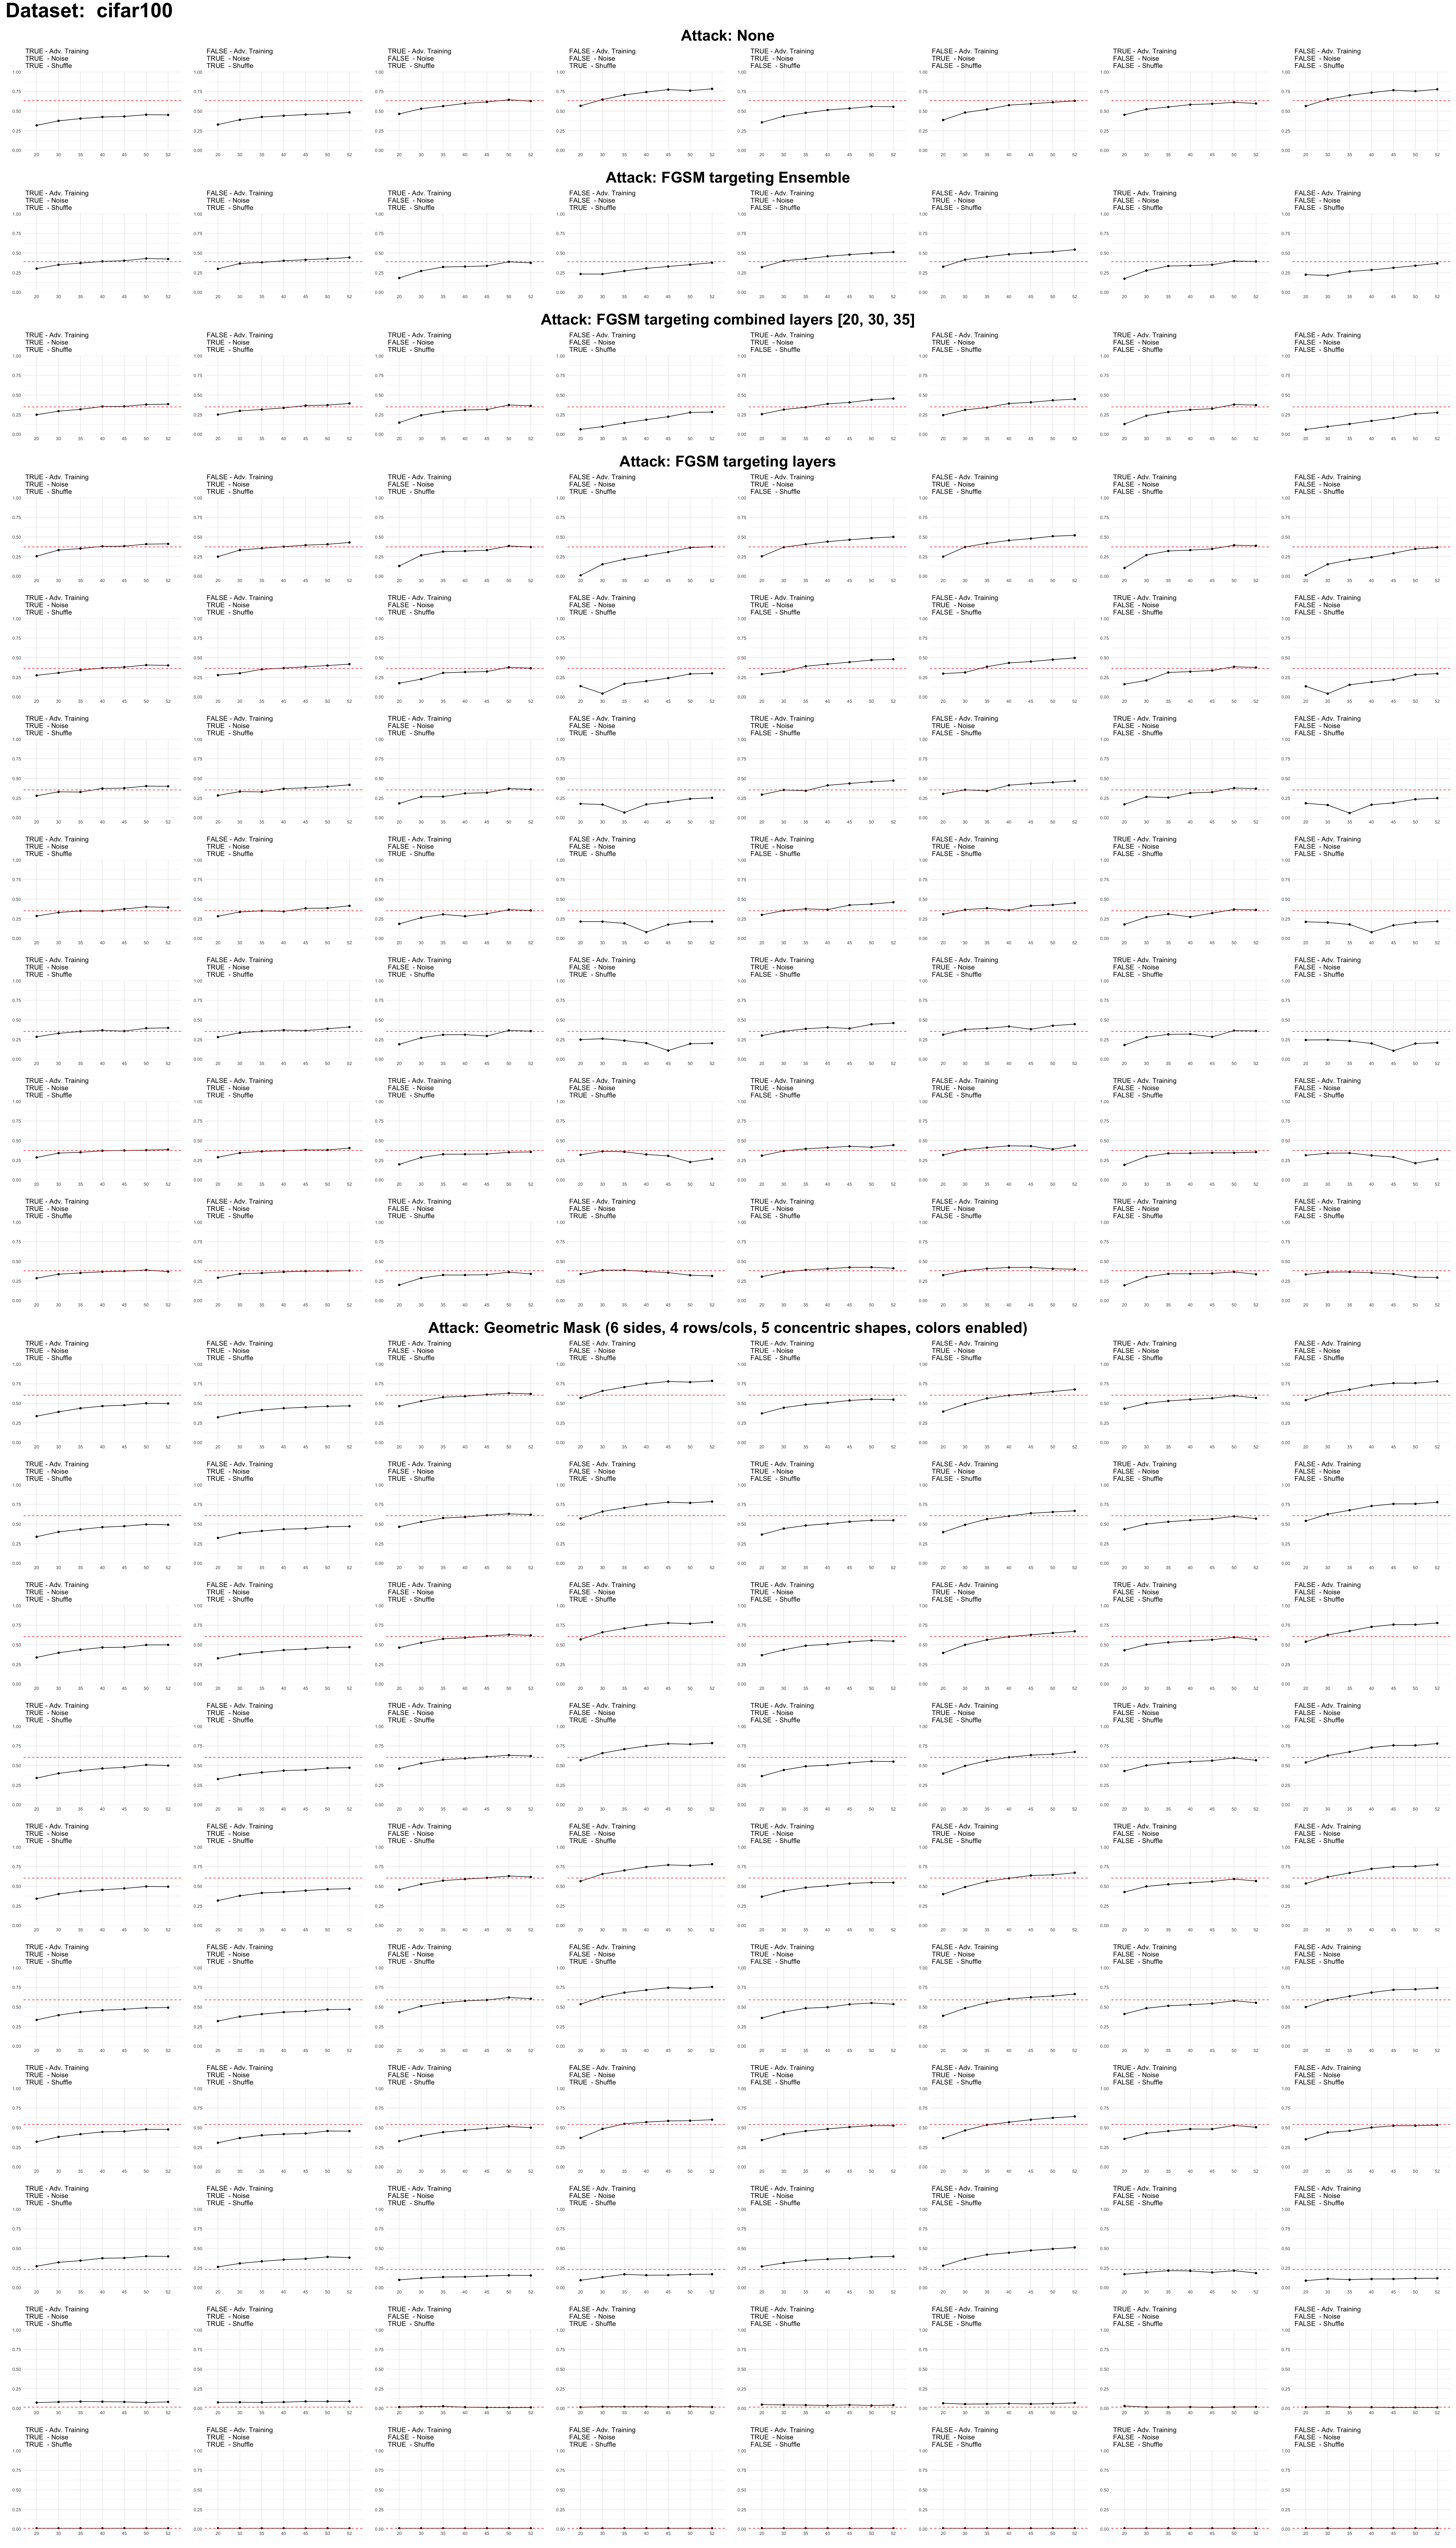

In [3]:
deps <- c("ISLR", "ndjson", "ggplot2", "dplyr", "caret", "tidyr", "gridExtra", "data.table", "repr", "reshape2", "grid", "patchwork")
for (p in deps) {
    if (!requireNamespace(p, quietly = TRUE)) {
        install.packages(p, repos = "https://cran.rstudio.com")
    }
    library(p, character.only = TRUE)
}
options(scipen=999)

df <- ndjson::stream_in("./self_ensemble.jsonl")
# print(names(df))

# df <- df[df$dataset == "cifar10",]
df <- df[df$dataset == "cifar100",]
# df <- df[df$dataset == "imagenette",] # <- doesn't work due to a bug

options(repr.plot.width=40, repr.plot.height=70)


get_plot <- function(acc_cols, acc_ensemble) {
    plots <- list()
    
    combs <- expand.grid(
        training_adversarial = c(TRUE, FALSE),
        training_noise = c(TRUE, FALSE),
        training_shuffle = c(TRUE, FALSE)
    )
    for (i in 1:nrow(combs)) {
        filtered_df <- df[df$training_adversarial == combs$training_adversarial[i] &
                       df$training_noise == combs$training_noise[i] &
                       df$training_shuffle == combs$training_shuffle[i], ]
        melted_df <- melt(filtered_df, measure.vars = acc_cols)

        p <- ggplot() +
            geom_line(data = melted_df, aes(x = variable, y = value, group = 1), color = "black") +
            geom_point(data = melted_df, aes(x = variable, y = value), color = "black") +
            geom_hline(yintercept = df[[acc_ensemble]][2], color = "red", linetype = "dashed", linewidth = 0.5) +
            xlab("") +
            ylab("") +
            theme_minimal() +
            scale_y_continuous(expand = c(0, 0), limits = c(0, 1)) + # limit y range
            scale_x_discrete(labels = function(x) sub(".*\\.", "", x)) + # show only layer number on x-axis
            ggtitle(paste(
                "", 
                combs$training_adversarial[i], "- Adv. Training \n",
                combs$training_noise[i], " - Noise \n",
                combs$training_shuffle[i], " - Shuffle"
            ))
        plots[[i]] <- p
    }

    combined_plot <- patchwork::wrap_plots(plots, ncol = 8)
    return(combined_plot)
}


plots <- list()

plots[[1]] <- textGrob("Attack: None", gp = gpar(fontsize = 30, fontface = "bold"))
plots[[2]] <- get_plot(
    c("plain_layer_accs.20", "plain_layer_accs.30", "plain_layer_accs.35", "plain_layer_accs.40", "plain_layer_accs.45", "plain_layer_accs.50", "plain_layer_accs.52"),
    "plain_ensemble_acc"
)

plots[[3]] <- textGrob("Attack: FGSM targeting Ensemble", gp = gpar(fontsize = 30, fontface = "bold"))
plots[[4]] <- get_plot(
    c("fgsmensemble_layer_accs.20", "fgsmensemble_layer_accs.30", "fgsmensemble_layer_accs.35", "fgsmensemble_layer_accs.40", "fgsmensemble_layer_accs.45", "fgsmensemble_layer_accs.50", "fgsmensemble_layer_accs.52"),
    "fgsmensemble_ensemble_acc"
)

plots[[5]] <- textGrob("Attack: FGSM targeting combined layers [20, 30, 35]", gp = gpar(fontsize = 30, fontface = "bold"))
plots[[6]] <- get_plot(
    c("fgsmcombined_[20, 30, 35]_layer_accs.20", "fgsmcombined_[20, 30, 35]_layer_accs.30", "fgsmcombined_[20, 30, 35]_layer_accs.35", "fgsmcombined_[20, 30, 35]_layer_accs.40", "fgsmcombined_[20, 30, 35]_layer_accs.45", "fgsmcombined_[20, 30, 35]_layer_accs.50", "fgsmcombined_[20, 30, 35]_layer_accs.52"),
    "fgsmcombined_[20, 30, 35]_ensemble_acc"
)

plots[[7]] <- textGrob("Attack: FGSM targeting layers", gp = gpar(fontsize = 30, fontface = "bold"))
layers <- c(20, 30, 35, 40, 45, 50, 52)
for (i in seq_along(layers)) {
    layer <- layers[i]
    acc_cols <- paste0("fgsm_", layer, "_layer_accs.", layers)
    ensemble_acc_col <- paste0("fgsm_", layer, "_ensemble_acc")
    p <- get_plot(acc_cols, ensemble_acc_col)
    plots[[7 + i]] <- p
}


plots[[length(plots) + 1]] <- textGrob("Attack: Geometric Mask (6 sides, 4 rows/cols, 5 concentric shapes, colors enabled)", gp = gpar(fontsize = 30, fontface = "bold"))
# https://github.com/ETH-DISCO/self-ensembling/blob/0482dd00f5ca64c118583875b934d626fbfceee9/1-resnet-single-mask/gen_mask.py
# num_sides=6,
# num_polygons_per_row=4,
# num_polygons_per_col=4,
# num_polygons_concentric=5,
# hcaptcha_colors=True,
opacities <- c(0, 1, 2, 4, 8, 16, 32, 64, 128, 255)
layers <- c(20, 30, 35, 40, 45, 50, 52)
for (opacity in opacities) {
    acc_cols <- paste0("mask_", opacity, "_layer_accs.", layers)
    ensemble_acc_col <- paste0("mask_", opacity, "_ensemble_acc")
    p <- get_plot(acc_cols, ensemble_acc_col)
    plots[[length(plots) + 1]] <- p
}

twidth <- 2
pwidth <- 10
n_layer_plots <- length(layers)
heights_vector <- c(
                    twidth, pwidth,
                    twidth, pwidth,
                    twidth, pwidth,
                    twidth, rep(pwidth, n_layer_plots),
                    twidth, rep(pwidth, length(opacities))
                )

p <- wrap_plots(
    ncol = 1,
    plots,
    heights = heights_vector
)

ds <- unique(df$dataset)
p <- p + plot_annotation(
    title = paste("Dataset: ", ds),
    theme = theme(plot.title = element_text(size = 40, face = "bold", hjust = 0))
)

print(p)
ggsave(paste("self_ensemble_8train_", ds, ".pdf", sep=""), p, width=40, height=70, limitsize=FALSE)